In [2]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_pe = pd.read_excel("PE_data/PE_processed_data.xlsx")

# 1. Demographics


## 1.1 Functions

In [4]:
def demographics_w_missing(df_data, diff_clm, lst_binary=None, lst_continuous=None, lst_categories=None, diff_ind=1):
    """
    Make the basic stats table of how many patients had eacch feature and then splitting that into 2 groups (typically survivors vs
    nonsurvivors) and computing a comparison for that

    :param df_vars: Dataframe - with the data, the different features/variables should be columns
    :param lst_binary: List - list of the columns labels with binary Data - will be then shown as "count (percentage)" and tested via the
        Chi-Square/Fisher exact test
    :param lst_continuous: List - list of the column names with continuous Data - will then be shown as "median (Q25 - Q75)" and compared
        via the indep. t-test/ mann-U-test

    :param diff_clm: String - name of the differentiator column

    :param save_path: String - path for saving the df as an excel table

    :return: None
    """

    if lst_binary is None:
        lst_binary = []
    if lst_continuous is None:
        lst_continuous = []
    if lst_categories is None:
        lst_categories = []

    def agg_binary_count_and_percentage(x):
        if x.empty:
            return np.nan

        val_cnt = x.dropna().value_counts()

        if 1 not in val_cnt.index:
            return "0 (0%)"

        ones_count = val_cnt.at[1]

        ones_percentage = x.value_counts(normalize=True).at[1] * 100
        ones_percentage = round(ones_percentage, 1)

        return "{} ({}%)".format(ones_count, ones_percentage)

    def agg_missing_w_percentage(x):
        n_missing = x.isna().sum()
        missing_percent = round(((x.isna().sum() / len(x)) * 100), 1)
        return "{} ({}%)".format(n_missing, missing_percent)

    def agg_continuous_median_and_iqr(x):
        if x.empty:
            return np.nan

        quantiles_cont = x.dropna().quantile(q=[0.25, 0.5, 0.75])
        quantiles = [quantiles_cont[0.25], quantiles_cont[0.50], quantiles_cont[0.75]]

        return "{} [{}-{}]".format(round(quantiles[1], 2), round(quantiles[0], 2), round(quantiles[2], 2))

    if len(lst_binary) > 0:
        lst_binary.append(diff_clm)
    lst_final_dfs = []

    df_binary = pd.DataFrame(
        columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Nonsurvivors",
                 "Nonsurvivors_missing_data", "p-value", "test"], index=lst_binary)
    df_continuous = pd.DataFrame(
        columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Nonsurvivors",
                 "Nonsurvivors_missing_data", "p-value", "test"],
        index=lst_continuous)

    ## binary variables
    # summarize binary variables
    if len(lst_binary) > 0:
        result_all_binary = df_data[lst_binary].apply(lambda x: agg_binary_count_and_percentage(x))
        df_binary.loc[:, "All patients"] = result_all_binary

        result_split_binary = (df_data[lst_binary].groupby(diff_clm)
                               .agg([agg_binary_count_and_percentage])
                               .droplevel(level=1, axis=1)
                               .transpose()
                               .rename(columns={0: "Survivors", 1: "Nonsurvivors"}))
        df_binary.loc[:, ["Survivors", "Nonsurvivors"]] = result_split_binary

        # p values binary
        for clm_binary in lst_binary:
            df_contigency = pd.crosstab(df_data[clm_binary], df_data[diff_clm])

            if (df_contigency < 5).any().any() == True:
                fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
                p_value = fisher_pvalue
                test_name = "Fisher Exact"
            else:
                chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
                p_value = chi_pvalue
                test_name = "Chi-Square"

            if p_value < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_value, 3)

            df_binary.loc[clm_binary, "p-value"] = p_value
            df_binary.loc[clm_binary, "test"] = test_name

        df_binary.loc[df_binary.Survivors.isna() | df_binary.Nonsurvivors.isna(), ["p-value", "test"]] = np.nan

        # missing binary
        all_binary_missing = df_data[lst_binary].apply(lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "All_pat_missing_data"] = all_binary_missing

        diff_binary_missing = df_data.loc[df_data[diff_clm] == diff_ind, lst_binary].apply(
            lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "Nonsurvivors_missing_data"] = diff_binary_missing

        anti_diff_binary_missing = df_data.loc[df_data[diff_clm] != diff_ind, lst_binary].apply(
            lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "Survivors_missing_data"] = anti_diff_binary_missing

        lst_final_dfs.append(df_binary)

    ## continuous variables
    # deskriptive continuous
    if len(lst_continuous) > 0:
        result_all_continuous = df_data[lst_continuous].apply(lambda x: agg_continuous_median_and_iqr(x))
        df_continuous.loc[:, "All patients"] = result_all_continuous

        lst_continuous_w_diff = lst_continuous + [diff_clm]

        result_split_continuous = (df_data[lst_continuous_w_diff].groupby(diff_clm)
                                   .agg([agg_continuous_median_and_iqr])
                                   .droplevel(level=1, axis=1)
                                   .transpose()
                                   .rename(columns={0: "Survivors", 1: "Nonsurvivors"}))
        df_continuous.loc[:, ["Survivors", "Nonsurvivors"]] = result_split_continuous

        # p-values continuous
        df_diff_clm = df_data.loc[df_data[diff_clm] == diff_ind, lst_continuous].copy()
        df_anti_diff_clm = df_data.loc[df_data[diff_clm] != diff_ind, lst_continuous].copy()

        for clm_cont in lst_continuous:
            df_diff_clm_var = df_diff_clm[clm_cont].dropna()
            df_anti_diff_var = df_anti_diff_clm[clm_cont].dropna()
            statistic_shap_0, p_shap_0 = stats.shapiro(df_anti_diff_var)
            statistic_shap_1, p_shap_1 = stats.shapiro(df_diff_clm_var)

            if p_shap_0 < 0.05 or p_shap_1 < 0.05:

                statistic_mann, p_value_mann = stats.mannwhitneyu(df_anti_diff_var, df_diff_clm_var)
                p_value = p_value_mann
                test_name = "Mann Whitney U"

            else:
                statistic_t, p_value_t = stats.ttest_ind(df_anti_diff_var, df_diff_clm_var, equal_var=False)
                p_value = p_value_t
                test_name = "Independent t-test"

            if p_value < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_value, 3)

            df_continuous.loc[clm_cont, "p-value"] = p_value
            df_continuous.loc[clm_cont, "test"] = test_name

        df_continuous.loc[df_continuous.Survivors.isna() | df_continuous.Nonsurvivors.isna(), ["p-value", "test"]] = np.nan

        # missing values continuous
        all_continuous_missing = df_data[lst_continuous].apply(lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "All_pat_missing_data"] = all_continuous_missing

        diff_continuous_missing = df_data.loc[df_data[diff_clm] == diff_ind, lst_continuous].apply(
            lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "Nonsurvivors_missing_data"] = diff_continuous_missing

        anti_diff_continuous_missing = df_data.loc[df_data[diff_clm] != diff_ind, lst_continuous].apply(
            lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "Survivors_missing_data"] = anti_diff_continuous_missing

        lst_final_dfs.append(df_continuous)

    ## categorical variables
    # transforming to binary
    if len(lst_categories) > 0:
        lst_cat_results_dfs = []
        df_data[lst_categories] = df_data[lst_categories].astype('object')

        for clm_cat in lst_categories:
            # prepare one category spread out
            df_one_cat = pd.get_dummies(df_data[clm_cat], clm_cat, dummy_na=True)
            df_one_cat[diff_clm] = df_data[diff_clm]
            df_one_cat = df_one_cat[df_one_cat[f"{clm_cat}_nan"] != 1].drop(columns=[f"{clm_cat}_nan"]).copy()

            df_category_temp = pd.DataFrame(
                columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Nonsurvivors",
                         "Nonsurvivors_missing_data", "p-value", "test"],
                index=df_one_cat.columns)

            # summary categorical
            result_all_cat_binary = df_one_cat.apply(lambda x: agg_binary_count_and_percentage(x))
            df_category_temp.loc[:, "All patients"] = result_all_cat_binary

            result_split_cat_binary = (df_one_cat.groupby(diff_clm)
                                       .agg([agg_binary_count_and_percentage])
                                       .droplevel(level=1, axis=1)
                                       .transpose()
                                       .rename(columns={0: "Survivors", 1: "Nonsurvivors"}))
            df_category_temp.loc[:, ["Survivors", "Nonsurvivors"]] = result_split_cat_binary

            # p values categorical
            for clm_cat_one in df_one_cat.columns:
                df_contigency_cat = pd.crosstab(df_one_cat[clm_cat_one], df_one_cat[diff_clm])

                if (df_contigency_cat < 5).any().any() == True:
                    fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency_cat)
                    p_value = fisher_pvalue
                    test_name = "Fisher Exact"
                else:
                    chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency_cat)
                    p_value = chi_pvalue
                    test_name = "Chi-Square"

                if p_value < 0.001:
                    p_value = "< 0.001"
                else:
                    p_value = round(p_value, 3)

                df_category_temp.loc[clm_cat_one, "p-value"] = p_value
                df_category_temp.loc[clm_cat_one, "test"] = test_name

            # missing values categorical
            one_cat_all_missing_total = df_data[clm_cat].isna().sum()
            one_cat_all_missing_percentage = round(((df_data[clm_cat].isna().sum() / len(df_data[clm_cat])) * 100), 1)
            df_category_temp.loc[:, "All_pat_missing_data"] = "{} ({}%)".format(one_cat_all_missing_total,
                                                                           one_cat_all_missing_percentage)

            one_cat_diff_missing_total = df_data.loc[df_data[diff_clm] == diff_ind, clm_cat].isna().sum()
            one_cat_diff_missing_percentage = round(((df_data.loc[
                                                          df_data[diff_clm] == diff_ind, clm_cat].isna().sum() / len(
                df_data.loc[df_data[diff_clm] == diff_ind, clm_cat])) * 100), 1)
            df_category_temp.loc[:, "Nonsurvivors_missing_data"] = "{} ({}%)".format(one_cat_diff_missing_total,
                                                                                one_cat_diff_missing_percentage)

            one_cat_anti_diff_missing_total = df_data.loc[df_data[diff_clm] != diff_ind, clm_cat].isna().sum()
            one_cat_anti_diff_missing_percentage = round(((df_data.loc[df_data[
                                                                           diff_clm] != diff_ind, clm_cat].isna().sum() / len(
                df_data.loc[df_data[diff_clm] != diff_ind, clm_cat])) * 100), 1)
            df_category_temp.loc[:, "Survivors_missing_data"] = "{} ({}%)".format(one_cat_anti_diff_missing_total,
                                                                                one_cat_anti_diff_missing_percentage)

            df_category_temp.loc[
                df_category_temp.Survivors.isna() | df_category_temp.Nonsurvivors.isna(), ["p-value", "test"]] = np.nan
            df_category_temp = df_category_temp.drop(diff_clm)
            lst_cat_results_dfs.append(df_category_temp)

        df_categories_final = pd.concat(lst_cat_results_dfs)
        lst_final_dfs.append(df_categories_final)

    df_final = pd.concat(lst_final_dfs)

    return df_final

## 1.2 Table 1: Demographics and comorbidities

In [5]:
df_pe.hospitaldischargestatus.value_counts(dropna=False)

0    1252
1      88
Name: hospitaldischargestatus, dtype: int64

In [6]:
lst_binary_1 = [
    "gender", "pmh_HT_with_treatment", 'pmh_venous_thromb_and_PE', 'pmh_CAD_and_other_large_vessel', 'pmh_CHF', 'pmh_arrhythmias_binary', 'pmh_any_pacemaker',
    'pmh_card_valvular', 'pmh_obstructive_LD', 'pmh_restrictive_lung_disease', 'pmh_home_o2', "pmh_seizures", "pmh_dementia", 'pmh_neuromusk_disease',
    'pmh_intracranial_mass', 'pmh_cancer_binary', 'pmh_anemias', 'pmh_sickle_cells', 'pmh_clotting_disorders_gen', 'pmh_ITP', 'pmh_diabetes_binary',
    'pmh_thyroid_disease', 'pmh_liver_cirrhosis', 'pmh_renal_insuff_binary'
]

lst_categorical_1 = ["ethnicity"]

lst_continuous_1 = ["age", "BMI", 'ICU_free_days']

In [7]:
df_table_1 = demographics_w_missing(df_data=df_pe,
                                     lst_binary=lst_binary_1,
                                     lst_continuous=lst_continuous_1,
                                     lst_categories=lst_categorical_1,
                                     diff_clm="hospitaldischargestatus",
                                     diff_ind=1)
df_table_1

,All patients,All_pat_missing_data,Survivors,Survivors_missing_data,Nonsurvivors,Nonsurvivors_missing_data,p-value,test
gender,661 (49.3%),0 (0.0%),621 (49.6%),0 (0.0%),40 (45.5%),0 (0.0%),0.521,Chi-Square
pmh_HT_with_treatment,626 (46.7%),0 (0.0%),585 (46.7%),0 (0.0%),41 (46.6%),0 (0.0%),1.0,Chi-Square
pmh_venous_thromb_and_PE,200 (14.9%),0 (0.0%),193 (15.4%),0 (0.0%),7 (8.0%),0 (0.0%),0.081,Chi-Square
pmh_CAD_and_other_large_vessel,188 (14.0%),0 (0.0%),173 (13.8%),0 (0.0%),15 (17.0%),0 (0.0%),0.494,Chi-Square
pmh_CHF,111 (8.3%),0 (0.0%),103 (8.2%),0 (0.0%),8 (9.1%),0 (0.0%),0.933,Chi-Square
pmh_arrhythmias_binary,110 (8.2%),0 (0.0%),100 (8.0%),0 (0.0%),10 (11.4%),0 (0.0%),0.36,Chi-Square
pmh_any_pacemaker,25 (1.9%),0 (0.0%),21 (1.7%),0 (0.0%),4 (4.5%),0 (0.0%),0.076,Fisher Exact
pmh_card_valvular,20 (1.5%),0 (0.0%),19 (1.5%),0 (0.0%),1 (1.1%),0 (0.0%),1.0,Fisher Exact
pmh_obstructive_LD,226 (16.9%),0 (0.0%),202 (16.1%),0 (0.0%),24 (27.3%),0 (0.0%),0.011,Chi-Square
pmh_restrictive_lung_disease,12 (0.9%),0 (0.0%),11 (0.9%),0 (0.0%),1 (1.1%),0 (0.0%),0.559,Fisher Exact


## 1.3 Table 2: Detailed comorbidities (supplementary) 

In [8]:
lst_categorical_2 = ["pmh_COPD", "pmh_arrhythmias", 'pmh_cancer_grouped_v2', 'pmh_diabetes', 'pmh_renal_insuff', "pmh_renal_failure", 'pmh_PE']


In [9]:
df_table_2 = demographics_w_missing(df_data=df_pe,
                                     lst_categories=lst_categorical_2,
                                     diff_clm="hospitaldischargestatus",
                                     diff_ind=1)
df_table_2

,All patients,All_pat_missing_data,Survivors,Survivors_missing_data,Nonsurvivors,Nonsurvivors_missing_data,p-value,test
pmh_COPD_0,1185 (88.4%),0 (0.0%),1116 (89.1%),0 (0.0%),69 (78.4%),0 (0.0%),0.004,Chi-Square
pmh_COPD_COPD_mild,53 (4.0%),0 (0.0%),48 (3.8%),0 (0.0%),5 (5.7%),0 (0.0%),0.564,Chi-Square
pmh_COPD_COPD_moderate,75 (5.6%),0 (0.0%),67 (5.4%),0 (0.0%),8 (9.1%),0 (0.0%),0.217,Chi-Square
pmh_COPD_COPD_severe,27 (2.0%),0 (0.0%),21 (1.7%),0 (0.0%),6 (6.8%),0 (0.0%),0.003,Chi-Square
pmh_arrhythmias_0,1230 (91.8%),0 (0.0%),1152 (92.0%),0 (0.0%),78 (88.6%),0 (0.0%),0.36,Chi-Square
pmh_arrhythmias_Afib_orwith,101 (7.5%),0 (0.0%),91 (7.3%),0 (0.0%),10 (11.4%),0 (0.0%),0.231,Chi-Square
pmh_arrhythmias_other_arrhythmia,9 (0.7%),0 (0.0%),9 (0.7%),0 (0.0%),0 (0%),0 (0.0%),1.0,Fisher Exact
pmh_cancer_grouped_v2_Breast,36 (2.7%),0 (0.0%),33 (2.6%),0 (0.0%),3 (3.4%),0 (0.0%),0.509,Fisher Exact
pmh_cancer_grouped_v2_GI,53 (4.0%),0 (0.0%),46 (3.7%),0 (0.0%),7 (8.0%),0 (0.0%),0.088,Chi-Square
pmh_cancer_grouped_v2_Genitourinary,49 (3.7%),0 (0.0%),44 (3.5%),0 (0.0%),5 (5.7%),0 (0.0%),0.451,Chi-Square


## 1.4 Table 3: Clinical variables

In [10]:
lst_binary_3 = ['infusion_anticoag', 'infusion_vaso_ino', 'infusion_thrombolytic', "pred_oobintubday1"]

lst_continuous_3 = [
    'potassium_median_0to1440', 'bicarbonate_median_0to1440', 'glucose_median_0to1440', 'creatinine_median_0to1440',  'BUN_median_0to1440', 'Hgb_median_0to1440',
    'platelets x 1000_median_0to1440', 'respiration_median_0to1440_u30', 'sao2_median_0to1440_u30', 'heartrate_median_0to1440_u30', 'systolic_median_0to1440_u30',
    'mean_bp_median_0to1440_u30', 'diastolic_median_0to1440_u30', "aps_GCS", 'aps_eyes', 'aps_motor', 'aps_verbal']

In [11]:
df_table_3 = demographics_w_missing(df_data=df_pe,
                                     lst_binary=lst_binary_3,
                                     lst_continuous=lst_continuous_3,
                                     diff_clm="hospitaldischargestatus",
                                     diff_ind=1)
df_table_3

,All patients,All_pat_missing_data,Survivors,Survivors_missing_data,Nonsurvivors,Nonsurvivors_missing_data,p-value,test
infusion_anticoag,501 (37.4%),0 (0.0%),468 (37.4%),0 (0.0%),33 (37.5%),0 (0.0%),1.0,Chi-Square
infusion_vaso_ino,73 (5.4%),0 (0.0%),48 (3.8%),0 (0.0%),25 (28.4%),0 (0.0%),< 0.001,Chi-Square
infusion_thrombolytic,49 (3.7%),0 (0.0%),48 (3.8%),0 (0.0%),1 (1.1%),0 (0.0%),0.369,Fisher Exact
pred_oobintubday1,109 (8.1%),0 (0.0%),69 (5.5%),0 (0.0%),40 (45.5%),0 (0.0%),< 0.001,Chi-Square
hospitaldischargestatus,88 (6.6%),0 (0.0%),NaN,0 (0.0%),NaN,0 (0.0%),NaN,NaN
potassium_median_0to1440,4.0 [3.7-4.3],191 (14.3%),4.0 [3.7-4.3],179 (14.3%),4.35 [3.98-4.72],12 (13.6%),< 0.001,Mann Whitney U
bicarbonate_median_0to1440,24.5 [22.0-27.0],273 (20.4%),25.0 [22.0-27.0],255 (20.4%),21.25 [17.62-25.0],18 (20.5%),< 0.001,Mann Whitney U
glucose_median_0to1440,119.0 [102.0-150.0],138 (10.3%),118.0 [101.0-147.0],131 (10.5%),133.0 [111.5-177.0],7 (8.0%),0.001,Mann Whitney U
creatinine_median_0to1440,0.9 [0.72-1.16],198 (14.8%),0.9 [0.72-1.12],185 (14.8%),1.3 [0.91-1.82],13 (14.8%),< 0.001,Mann Whitney U
BUN_median_0to1440,16.0 [11.0-23.0],201 (15.0%),15.0 [11.0-22.0],189 (15.1%),27.0 [18.0-36.0],12 (13.6%),< 0.001,Mann Whitney U


## 1.5 Table 4: Scores at ICU entry

In [12]:
lst_binary_4 = [
    'PESI_pulm', 'PESI_hf', 'PESI_cancer', 'PESI_pulse', 'PESI_systolic', 'PESI_temp', 'PESI_resp', 'PESI_o2', 'PESI_ams',
    'sPESI_age', 'sPESI_cancer', 'sPESI_cardiopulm', 'sPESI_pulse', 'sPESI_systolic', 'sPESI_o2',
]

lst_categorical_4 = ['PESI_class', 'sPESI_score']

lst_continuous_4 = ["apachescore", "predictedhospitalmortality", "PESI_score", "sPESI_score"]

In [13]:
df_table_4 = demographics_w_missing(df_data=df_pe,
                                     lst_binary=lst_binary_4,
                                     lst_continuous=lst_continuous_4,
                                     lst_categories=lst_categorical_4,
                                     diff_clm="hospitaldischargestatus",
                                     diff_ind=1)
df_table_4

C:\Users\Martin Ryll\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\Martin Ryll\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,All patients,All_pat_missing_data,Survivors,Survivors_missing_data,Nonsurvivors,Nonsurvivors_missing_data,p-value,test
PESI_pulm,239 (17.8%),0 (0.0%),213 (17.0%),0 (0.0%),26 (29.5%),0 (0.0%),0.005,Chi-Square
PESI_hf,111 (8.3%),0 (0.0%),103 (8.2%),0 (0.0%),8 (9.1%),0 (0.0%),0.933,Chi-Square
PESI_cancer,93 (6.9%),0 (0.0%),78 (6.2%),0 (0.0%),15 (17.0%),0 (0.0%),< 0.001,Chi-Square
PESI_pulse,667 (49.8%),0 (0.0%),601 (48.0%),0 (0.0%),66 (75.0%),0 (0.0%),< 0.001,Chi-Square
PESI_systolic,748 (55.8%),0 (0.0%),678 (54.2%),0 (0.0%),70 (79.5%),0 (0.0%),< 0.001,Chi-Square
PESI_temp,124 (9.3%),0 (0.0%),101 (8.1%),0 (0.0%),23 (26.1%),0 (0.0%),< 0.001,Chi-Square
PESI_resp,699 (52.2%),0 (0.0%),631 (50.4%),0 (0.0%),68 (77.3%),0 (0.0%),< 0.001,Chi-Square
PESI_o2,439 (32.8%),0 (0.0%),383 (30.6%),0 (0.0%),56 (63.6%),0 (0.0%),< 0.001,Chi-Square
PESI_ams,179 (13.4%),0 (0.0%),138 (11.0%),0 (0.0%),41 (46.6%),0 (0.0%),< 0.001,Chi-Square
sPESI_age,192 (14.3%),0 (0.0%),170 (13.6%),0 (0.0%),22 (25.0%),0 (0.0%),0.005,Chi-Square


# 2. Graphs and other statistical analysis

## 2.1 Functions

In [14]:
def calc_AUC_SE(auc, n_pos, n_neg):
    """
    Function to calculate the SE for the AUC of a ROC curve

    :param auc: Float - AUC value
    :param n_pos: Int - number of true positive samples/patients (in total from y true, not the PPV!)
    :param n_neg: Int - number of true negative samples/patients (in total from y true, not the NPV!)
    :return: Float - the standard error for the AUC
    """
    q1 = auc / (2 - auc)
    q2 = (2 * (auc ** 2)) / (1 + auc)

    se_auc = math.sqrt((auc * (1 - auc) + (n_pos - 1) * (q1 - auc ** 2) + (n_neg - 1) * (q2 - auc ** 2)) / (n_pos * n_neg))

    return se_auc


def calc_auc_correlation(auc1, auc2, y_true, test1, test2, kind_scoring="interval"):
    """
    Calculates the correlation of 2 AUCs that are derived from 2 different models on the same data.

    :param auc1: Float - AUC value for model 1
    :param auc2: Float - AUC value for model 1
    :param y_true: numpy array - the true labels
    :param test1: numpy array - the array of the score-values of score from the first model
    :param test2: numpy array - the array of the score-values of score from the second model
    :param kind_scoring: String, Picklist either "interval" or "ordinal", default "interval" - whether to use the pearson-r (interval)
        or the kendall-tau (ordinal) to calculate the correlation
    :return: Float - a correlation value
    """
    # correlation for the negative patients
    test1_on_neg = test1[y_true == 0]
    test2_on_neg = test2[y_true == 0]

    if kind_scoring == "interval":
        r_neg, p = stats.pearsonr(test1_on_neg, test2_on_neg)
    else:
        r_neg, p = stats.kendalltau(test1_on_neg, test2_on_neg)

    # correlation for the positive patients
    test1_on_true = test1[y_true == 1]
    test2_on_true = test2[y_true == 1]

    if kind_scoring == "interval":
        r_pos, p = stats.pearsonr(test1_on_true, test2_on_true)
    else:
        r_pos, p = stats.kendalltau(test1_on_true, test2_on_true)

    # averages
    auc_av = (auc1 + auc2) / 2
    r_av = (r_neg + r_pos) / 2

    # lookup final R
    dict_r_lookup_paired_auc = {
        "r_average": [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4,
                      0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8,
                      0.82, 0.84, 0.86, 0.88, 0.9],
        0.7: [0.02, 0.04, 0.05, 0.07, 0.09, 0.11, 0.13, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39,
              0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.82,
              0.84, 0.86, 0.88],
        0.725: [0.02, 0.04, 0.05, 0.07, 0.09, 0.11, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39,
                0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81,
                0.84, 0.86, 0.88],
        0.75: [0.02, 0.03, 0.05, 0.07, 0.09, 0.11, 0.12, 0.14, 0.16, 0.18, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.32, 0.34, 0.36, 0.38,
               0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.75, 0.77, 0.79, 0.81,
               0.83, 0.86, 0.88],
        0.775: [0.02, 0.03, 0.05, 0.07, 0.09, 0.1, 0.12, 0.14, 0.16, 0.17, 0.19, 0.21, 0.23, 0.25, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38,
                0.4, 0.42, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.79, 0.81,
                0.83, 0.85, 0.88],
        0.8: [0.02, 0.03, 0.05, 0.07, 0.08, 0.1, 0.12, 0.13, 0.15, 0.17, 0.19, 0.21, 0.22, 0.24, 0.26, 0.28, 0.3, 0.31, 0.33, 0.35, 0.37,
              0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.69, 0.72, 0.74, 0.76, 0.78, 0.81,
              0.83, 0.85, 0.87],
        0.825: [0.02, 0.03, 0.05, 0.06, 0.08, 0.1, 0.11, 0.13, 0.15, 0.17, 0.18, 0.2, 0.22, 0.24, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.36,
                0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.65, 0.67, 0.69, 0.71, 0.73, 0.76, 0.78, 0.8,
                0.82, 0.85, 0.87],
        0.85: [0.02, 0.03, 0.05, 0.06, 0.08, 0.09, 0.11, 0.13, 0.14, 0.16, 0.18, 0.19, 0.21, 0.23, 0.25, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36,
               0.38, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.71, 0.73, 0.75, 0.77, 0.8,
               0.82, 0.84, 0.87],
        0.875: [0.01, 0.03, 0.04, 0.06, 0.07, 0.09, 0.11, 0.12, 0.14, 0.15, 0.17, 0.19, 0.2, 0.22, 0.24, 0.26, 0.27, 0.29, 0.31, 0.33, 0.35,
                0.37, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.7, 0.72, 0.74, 0.77, 0.79,
                0.81, 0.84, 0.86],
        0.9: [0.01, 0.03, 0.04, 0.06, 0.07, 0.08, 0.1, 0.11, 0.13, 0.15, 0.16, 0.18, 0.19, 0.21, 0.23, 0.24, 0.26, 0.28, 0.3, 0.32, 0.33,
              0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.6, 0.62, 0.64, 0.66, 0.69, 0.71, 0.73, 0.76, 0.78,
              0.81, 0.83, 0.86],
        0.925: [0.01, 0.02, 0.04, 0.05, 0.06, 0.08, 0.09, 0.11, 0.12, 0.14, 0.15, 0.17, 0.18, 0.2, 0.21, 0.23, 0.25, 0.26, 0.28, 0.3, 0.32,
                0.34, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.54, 0.56, 0.58, 0.6, 0.63, 0.65, 0.67, 0.7, 0.72, 0.75, 0.77,
                0.8, 0.82, 0.85],
        0.95: [0.01, 0.02, 0.03, 0.04, 0.06, 0.07, 0.08, 0.09, 0.11, 0.12, 0.14, 0.15, 0.16, 0.18, 0.19, 0.21, 0.23, 0.24, 0.26, 0.28, 0.29,
               0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.56, 0.58, 0.6, 0.63, 0.65, 0.68, 0.7, 0.73, 0.76,
               0.78, 0.81, 0.84],
        0.975: [0.01, 0.02, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.09, 0.1, 0.11, 0.12, 0.13, 0.15, 0.16, 0.18, 0.19, 0.21, 0.22, 0.24, 0.25,
                0.27, 0.29, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.45, 0.47, 0.49, 0.51, 0.54, 0.56, 0.59, 0.61, 0.64, 0.67, 0.7, 0.73,
                0.75, 0.79, 0.82]
    }
    df_r_lookup = pd.DataFrame(dict_r_lookup_paired_auc)
    df_r_lookup = df_r_lookup.set_index("r_average")

    index_array = df_r_lookup.index.to_numpy()
    clms_array = df_r_lookup.columns.to_numpy()

    final_r = df_r_lookup.at[index_array[np.abs(index_array - r_av).argmin()], clms_array[np.abs(clms_array - auc_av).argmin()]]

    return final_r


def compare_AUCs_paired(auc1, auc2, y_true, test1, test2, kind_scoring="interval"):
    """
    Compare 2 AUCs which are derived from 2 different models on the same data statistically.

    :param auc1: Float - AUC value for model 1
    :param auc2: Float - AUC value for model 1
    :param y_true: numpy array - the true labels
    :param test1: numpy array - the array of the score-values of score from the first model
    :param test2: numpy array - the array of the score-values of score from the second model
    :param kind_scoring: String, Picklist either "interval" or "ordinal", default "interval" - whether to use the pearson-r (interval)
        or the kendall-tau (ordinal) to calculate the correlation
    :return: Float - p value
    """
    n_pos = np.count_nonzero(y_true == 1)
    n_neg = np.count_nonzero(y_true == 0)

    se_auc1 = calc_AUC_SE(auc1, n_pos, n_neg)
    se_auc2 = calc_AUC_SE(auc2, n_pos, n_neg)

    r_aucs = calc_auc_correlation(auc1, auc2, y_true, test1, test2, kind_scoring=kind_scoring)

    se_auc1_vs_auc2 = math.sqrt(se_auc1 ** 2 + se_auc2 ** 2 - 2 * r_aucs * se_auc1 * se_auc2)

    z_stat = (auc1 - auc2) / se_auc1_vs_auc2

    p_value = stats.norm.sf(abs(z_stat)) * 2

    return p_value


def compare_AUCs_independent(auc1, auc2, n_pos1, n_neg1, n_pos2, n_neg2):
    """
    Compare 2 independent AUCs (as in 2 different models on 2 differen patient populations)  models on the same data statistically.
    :param auc1: Float - AUC value for model 1
    :param auc2: Float - AUC value for model 1
    :param n_pos1: Int - number of true positive samples/patients (in total from y true, not the PPV!) from model 1
    :param n_neg1: Int - number of true negative samples/patients (in total from y true, not the NPV!) from model 1
    :param n_pos2: Int - number of true positive samples/patients (in total from y true, not the PPV!) from model 2
    :param n_neg2: Int - number of true negative samples/patients (in total from y true, not the NPV!) from model 2
    :return: p-value
    """
    se_auc1 = calc_AUC_SE(auc1, n_pos1, n_neg1)
    se_auc2 = calc_AUC_SE(auc2, n_pos2, n_neg2)

    se_auc1_vs_auc2 = math.sqrt(se_auc1 ** 2 + se_auc2 ** 2)

    z_stat = (auc1 - auc2) / se_auc1_vs_auc2

    p_value = stats.norm.sf(abs(z_stat)) * 2

    return p_value

In [15]:
def calc_spec(threshold, y_true, pred):
    """
    Calculate the specificity for a prediction at a certain threshold

    :param threshold: Float - threshold as to where the labels (0/1) should be split/decided for the predictions
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param pred: Numpy array - numpy array of the predictions (percentages!)
    :return: specificity
    """

    pred_labels = np.where(pred > threshold, 1, 0)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_labels).ravel()

    if tn == 0 or (tn + fp) == 0:
        return 0

    spec = tn / (tn + fp)

    return spec


def calc_sens(threshold, y_true, pred):
    """
    Calculate the sensitivity for a prediction at a certain threshold

    :param threshold: Float - threshold as to where the labels (0/1) should be split/decided for the predictions
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param pred: Numpy array - numpy array of the predictions (percentages!)
    :return: sensitivity
    """
    pred_labels = np.where(pred > threshold, 1, 0)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_labels).ravel()


    if tp == 0 or (tp + fn) == 0:
        return 0

    sens = tp / (tp + fn)
    #print(threshold, sens)

    return sens


def calc_ppv(threshold, y_true, pred):
    """
    Calculate the sensitivity for a prediction at a certain threshold

    :param threshold: Float - threshold as to where the labels (0/1) should be split/decided for the predictions
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param pred: Numpy array - numpy array of the predictions (percentages!)
    :return: sensitivity
    """
    pred_labels = np.where(pred > threshold, 1, 0)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_labels).ravel()

    if tp == 0 or (tp + fp) == 0:
        return 0

    ppv = tp / (tp + fp)

    return ppv


def calc_npv(threshold, y_true, pred):
    """
    Calculate the sensitivity for a prediction at a certain threshold

    :param threshold: Float - threshold as to where the labels (0/1) should be split/decided for the predictions
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param pred: Numpy array - numpy array of the predictions (percentages!)
    :return: sensitivity
    """
    pred_labels = np.where(pred > threshold, 1, 0)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_labels).ravel()

    if tn == 0 or (tn + fn) == 0:
        return 0

    npv = tn / (tn + fn)

    return npv

def get_best_threshold_for_sens_spec_ppv_npv(prediction, y_true, type_stat, target_stat):
    """
    Get the best threshold at which an array of predictions is over a certain sensitivity/specificity/PPV/NPV. For specificity and PPV it
    will look for the lowest threshold. For sensitivity and NPV it will look for the highest threshold.

    :param prediction: Numpy array - numpy array of the predictions (percentages!)
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param type_stat: String, picklist either "sens", "spec", "ppv", "npv" -  whether to calculate the threshold for sensitivity,
    specificity, PPV, NPV
    :param target_stat: Float - Target value for the sensitivity/specificity
    :return: threshold for the target sensitivity/specificity/PPV/NPV
    """
    # Ensure that the input is valid


    # Sort the predictions and true labels in descending order
    sorted_indices = np.argsort(prediction)
    sorted_prediction = prediction[sorted_indices]
    sorted_y_true = y_true[sorted_indices]

    if type_stat == "sens":
        # calculate the sensitivity at every point of the sorted predictions:

        v_sens = np.vectorize(calc_sens, excluded=["y_true", "pred"])
        sens_array = v_sens(threshold=sorted_prediction, y_true=sorted_y_true, pred=sorted_prediction)
        sorted_prediction_reduced = sorted_prediction[(sens_array - target_stat) >= 0]

        if sorted_prediction_reduced.size == 0:
            return -1

        return sorted_prediction_reduced.min()

    if type_stat == "spec":
        # calculate the sensitivity at every point of the sorted predictions:

        v_spec = np.vectorize(calc_spec, excluded=["y_true", "pred"])
        spec_array = v_spec(threshold=sorted_prediction, y_true=sorted_y_true, pred=sorted_prediction)

        sorted_prediction_reduced = sorted_prediction[(spec_array - target_stat) >= 0]

        if sorted_prediction_reduced.size == 0:
            return -1

        return sorted_prediction_reduced.min()

    if type_stat == "ppv":
        # calculate the sensitivity at every point of the sorted predictions:

        v_ppv = np.vectorize(calc_ppv, excluded=["y_true", "pred"])
        ppv_array = v_ppv(threshold=sorted_prediction, y_true=sorted_y_true, pred=sorted_prediction)

        sorted_prediction_reduced = sorted_prediction[(ppv_array - target_stat) >= 0]

        if sorted_prediction_reduced.size == 0:
            return -1

        return sorted_prediction_reduced.min()

    if type_stat == "npv":
        # calculate the sensitivity at every point of the sorted predictions:

        v_npv = np.vectorize(calc_npv, excluded=["y_true", "pred"])
        npv_array = v_npv(threshold=sorted_prediction, y_true=sorted_y_true, pred=sorted_prediction)

        sorted_prediction_reduced = sorted_prediction[(npv_array - target_stat) >= 0]

        if sorted_prediction_reduced.size == 0:
            return -1

        return sorted_prediction_reduced.max()

    else:
        print("ERROR")
        return "ERROR"
    
def get_best_thresholds_for_stats_grid(prediction, y_true):
    """
    Get the best thresholds of the score at which an array of predictions (the score) has either a certain (or closest to) sensitivity/
    specificity/PPV/NPV.

    :param prediction: Numpy array - numpy array of the predictions (percentages or directly the score)
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param type_stat: String, picklist either "sens", "spec", "ppv", "npv" -  whether to calculate the threshold for sensitivity,
    specificity, PPV, NPV
    :return: dataframe with the threshold for the targets 0.8, 0.85, 0.9, 0.95, 0.975, 0.99
    """

    lst_modes = ["sens", "spec", "ppv", "npv"]
    lst_targets = [0.8, 0.85, 0.9, 0.95, 0.975, 0.99]

    lst_rows = []

    for mode in lst_modes:
        for target in lst_targets:
            value = get_best_threshold_for_sens_spec_ppv_npv(prediction, y_true, mode, target)

            metrics_row = pd.DataFrame(
                {
                    "metric": mode,
                    "target_threshold": target,
                    "value": value,

                }, index=[0]
            )

            lst_rows.append(metrics_row)

    df_metrics = pd.concat(lst_rows)

    return df_metrics

## 2.2 APACHE IVa, PESI and sPESI ROC curves

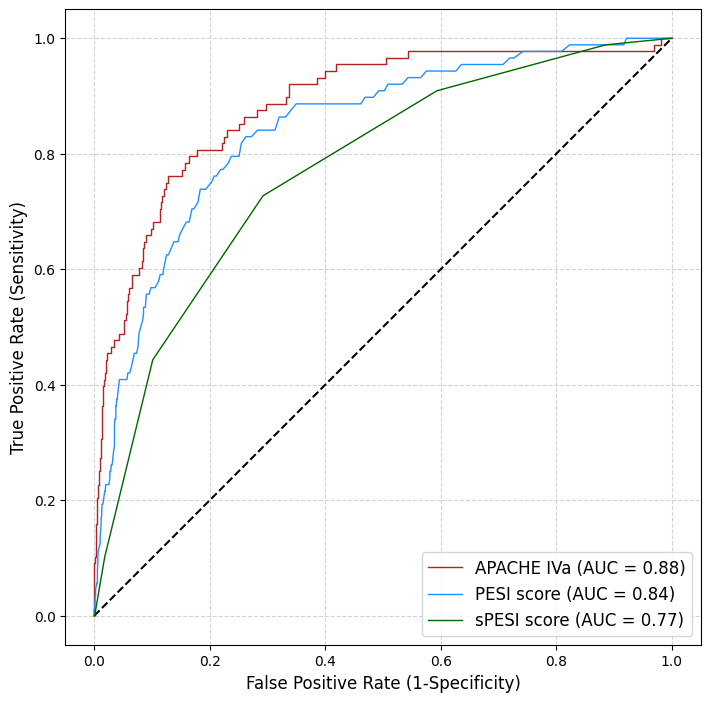

In [16]:
# initialize the plots
plt.rc('legend', fontsize = 12)
fig, ax_roc_hosp = plt.subplots(1, 1, figsize=(7,7))

ax_roc_hosp.plot([0, 1], [0, 1], "k--")

temp_outcome = df_pe["hospitaldischargestatus"].copy()
np_temp_outcome = temp_outcome.to_numpy()

# APACHE 
temp_apachepred = df_pe["predictedhospitalmortality"].copy()
np_temp_apache_pred = temp_apachepred.to_numpy()
np_temp_apache_score_raw = df_pe.apachescore.to_numpy()

fpr_apache, tpr_apache, _ = metrics.roc_curve(np_temp_outcome,  np_temp_apache_pred)
auc_apache = metrics.roc_auc_score(np_temp_outcome, np_temp_apache_pred)

# PESI Score 
np_temp_pesi_score_raw = df_pe.PESI_score.to_numpy()
fpr_pesi, tpr_pesi, _ = metrics.roc_curve(np_temp_outcome,  np_temp_pesi_score_raw)
auc_pesi = metrics.roc_auc_score(np_temp_outcome, np_temp_pesi_score_raw)

# sPESI score
np_temp_spesi_score_raw = df_pe.sPESI_score.to_numpy()
fpr_spesi, tpr_spesi, _ = metrics.roc_curve(np_temp_outcome,  np_temp_spesi_score_raw)
auc_spesi = metrics.roc_auc_score(np_temp_outcome, np_temp_spesi_score_raw)

# ROC curve
ax_roc_hosp.plot(
    fpr_apache, 
    tpr_apache, 
    label="APACHE IVa (AUC = {})".format(round(auc_apache, 2)),
    c="firebrick",
    lw=1
)

ax_roc_hosp.plot(
    fpr_pesi, 
    tpr_pesi, 
    label="PESI score (AUC = {})".format(round(auc_pesi, 2)),
    c="dodgerblue",
    lw=1
)

ax_roc_hosp.plot(
    fpr_spesi, 
    tpr_spesi, 
    label="sPESI score (AUC = {})".format(round(auc_spesi, 2)),
    c="darkgreen",
    lw=1
)
        

ax_roc_hosp.set_xlabel("False Positive Rate (1-Specificity)", fontsize=12)
ax_roc_hosp.set_ylabel("True Positive Rate (Sensitivity)", fontsize=12)
ax_roc_hosp.grid(color='lightgray', linestyle='dashed')
ax_roc_hosp.axis("square")
ax_roc_hosp.legend()
    
plt.tight_layout(pad=0.4, w_pad=0, h_pad=4.0)

plt.show()
plt.clf()

## 2.3 Comparing the ROC curves - p-values

In [17]:
p_val_apache_pesi = compare_AUCs_paired(auc1=auc_apache, 
                                        auc2=auc_pesi, 
                                        y_true=np_temp_outcome, 
                                        test1=np_temp_apache_score_raw, 
                                        test2=np_temp_pesi_score_raw, 
                                        kind_scoring="interval")


p_val_apache_spesi = compare_AUCs_paired(auc1=auc_apache, 
                                        auc2=auc_spesi, 
                                        y_true=np_temp_outcome, 
                                        test1=np_temp_apache_score_raw, 
                                        test2=np_temp_spesi_score_raw, 
                                        kind_scoring="ordinal")


p_val_pesi_spesi = compare_AUCs_paired(auc1=auc_pesi, 
                                        auc2=auc_spesi, 
                                        y_true=np_temp_outcome, 
                                        test1=np_temp_pesi_score_raw, 
                                        test2=np_temp_spesi_score_raw, 
                                        kind_scoring="ordinal")

print("p-value APACHE IVa vs PESI: {}".format(p_val_apache_pesi))
print("p-value APACHE IVa vs sPESI: {}".format(p_val_apache_spesi))
print("p-value PESI vs sPESI: {}".format(p_val_pesi_spesi))

p-value APACHE IVa vs PESI: 0.05936658971001876
p-value APACHE IVa vs sPESI: 0.000881581151302593
p-value PESI vs sPESI: 0.016096936839139996


## 2.4 Correlation APACHE IV and PESI

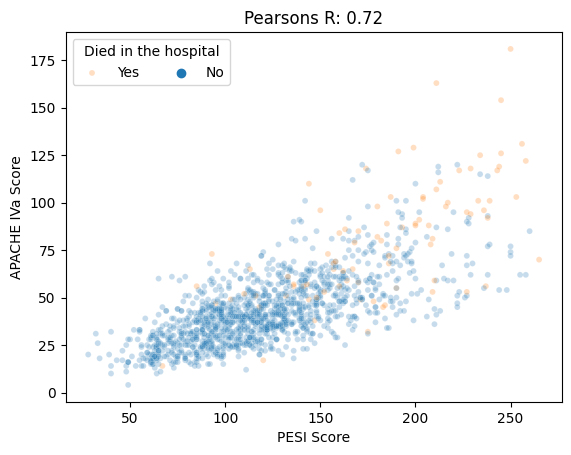

In [18]:
fig_corr_apache_pesi = sns.scatterplot(df_pe, x="PESI_score", y="apachescore", alpha=0.25, legend="brief", hue="hospitaldischargestatus", size=3)

pearsons_r, p_val = stats.pearsonr(df_pe.PESI_score, df_pe.apachescore)
fig_corr_apache_pesi.set_title("Pearsons R: {}".format(round(pearsons_r, 2)))
fig_corr_apache_pesi.set_xlabel("PESI Score", fontsize=10)
fig_corr_apache_pesi.set_ylabel("APACHE IVa Score", fontsize=10)
fig_corr_apache_pesi.legend(title="Died in the hospital", labels=["Yes", "No"], ncol=2, fontsize=10)

plt.show()
plt.clf()

## 2.5 Negative predictive values (NPVs)

In [19]:
pesi_thresh_NPV99 = get_best_threshold_for_sens_spec_ppv_npv(prediction=df_pe.PESI_score.to_numpy(), 
                                                             y_true=df_pe.hospitaldischargestatus.to_numpy(), 
                                                             type_stat="npv", 
                                                             target_stat=0.99)

pesi_thresh_NPV975 = get_best_threshold_for_sens_spec_ppv_npv(prediction=df_pe.PESI_score.to_numpy(), 
                                                             y_true=df_pe.hospitaldischargestatus.to_numpy(), 
                                                             type_stat="npv", 
                                                             target_stat=0.975)

pesi_thresh_NPV95 = get_best_threshold_for_sens_spec_ppv_npv(prediction=df_pe.PESI_score.to_numpy(), 
                                                             y_true=df_pe.hospitaldischargestatus.to_numpy(), 
                                                             type_stat="npv", 
                                                             target_stat=0.95)

print(f"99% NPV threshold for the PESI: {pesi_thresh_NPV99}")
print(f"97.5% NPV threshold for the PESI: {pesi_thresh_NPV975}")
print(f"95% NPV threshold for the PESI: {pesi_thresh_NPV95}")

99% NPV threshold for the PESI: 109
97.5% NPV threshold for the PESI: 159
95% NPV threshold for the PESI: 210


In [20]:
spesi_thresh_NPV99 = get_best_threshold_for_sens_spec_ppv_npv(prediction=df_pe.sPESI_score.to_numpy(), 
                                                             y_true=df_pe.hospitaldischargestatus.to_numpy(), 
                                                             type_stat="npv", 
                                                             target_stat=0.99)

spesi_thresh_NPV975 = get_best_threshold_for_sens_spec_ppv_npv(prediction=df_pe.sPESI_score.to_numpy(), 
                                                             y_true=df_pe.hospitaldischargestatus.to_numpy(), 
                                                             type_stat="npv", 
                                                             target_stat=0.975)

spesi_thresh_NPV95 = get_best_threshold_for_sens_spec_ppv_npv(prediction=df_pe.sPESI_score.to_numpy(), 
                                                             y_true=df_pe.hospitaldischargestatus.to_numpy(), 
                                                             type_stat="npv", 
                                                             target_stat=0.95)

print(f"99% NPV threshold for the sPESI: {spesi_thresh_NPV99}")
print(f"97.5% NPV threshold for the sPESI: {spesi_thresh_NPV975}")
print(f"95% NPV threshold for the sPESI: {spesi_thresh_NPV95}")

99% NPV threshold for the sPESI: 0
97.5% NPV threshold for the sPESI: 1
95% NPV threshold for the sPESI: 3


In [21]:
apache_thresh_NPV99 = get_best_threshold_for_sens_spec_ppv_npv(prediction=df_pe.apachescore.to_numpy(), 
                                                             y_true=df_pe.hospitaldischargestatus.to_numpy(), 
                                                             type_stat="npv", 
                                                             target_stat=0.99)

apache_thresh_NPV975 = get_best_threshold_for_sens_spec_ppv_npv(prediction=df_pe.apachescore.to_numpy(), 
                                                             y_true=df_pe.hospitaldischargestatus.to_numpy(), 
                                                             type_stat="npv", 
                                                             target_stat=0.975)

apache_thresh_NPV95 = get_best_threshold_for_sens_spec_ppv_npv(prediction=df_pe.apachescore.to_numpy(), 
                                                             y_true=df_pe.hospitaldischargestatus.to_numpy(), 
                                                             type_stat="npv", 
                                                             target_stat=0.95)

print(f"99% NPV threshold for the APACHE IVa Score: {apache_thresh_NPV99}")
print(f"97.5% NPV threshold for the APACHE IVa Score: {apache_thresh_NPV975}")
print(f"95% NPV threshold for the APACHE IVa Score: {apache_thresh_NPV95}")

99% NPV threshold for the APACHE IVa Score: 47
97.5% NPV threshold for the APACHE IVa Score: 56
95% NPV threshold for the APACHE IVa Score: 100


## 2.6 Mortality per score-point/bin and score distribution

<Figure size 640x480 with 0 Axes>

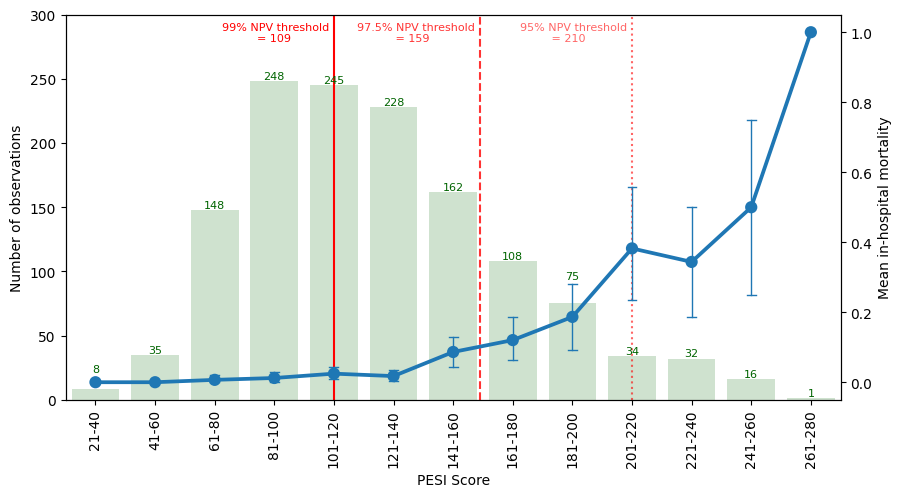

In [22]:
df_pe["PESI_score_bins"] = pd.cut(df_pe.PESI_score, bins=np.arange(20, 300, 20))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot with counts per score group
counts = df_pe["PESI_score_bins"].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values, alpha=0.2, color="green", ax=ax1)
ax1.set_xlabel("PESI Score", fontsize=10)
ax1.set_ylabel("Number of observations", fontsize=10)

# Adding the number of observations at the top of each bar
for i, p in enumerate(ax1.patches):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    
    if i == 0:
        y += 12
    elif i==8:
        y += 17
        
    ax1.text(x, y, counts.values[i], ha='center', va='bottom', fontsize=8, color="darkgreen")

    
ax1.set(ylim=(0, 300))

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Pointplot
sns.pointplot(data=df_pe, x="PESI_score_bins", y="hospitaldischargestatus",
              errwidth=1, capsize=0.15, ax=ax2)
ax2.set_ylabel("Mean in-hospital mortality", fontsize=10)

# Vertical red line at the 5th score bin
ax1.axvline(x=4, color='red', linestyle='-')
ax1.text(x=(2.12), y=(ax1.get_ylim()[1] * 0.93), s='99% NPV threshold \n          = 109', color='red', fontsize=8)

ax1.axvline(x=6.45, color='red', linestyle='--', alpha=0.8)
ax1.text(x=(4.38), y=(ax1.get_ylim()[1] * 0.93), s='97.5% NPV threshold\n           = 159', color='red', alpha=0.8, fontsize=8)

ax1.axvline(x=9, color='red', linestyle='dotted', alpha=0.6)
ax1.text(x=(7.12), y=(ax1.get_ylim()[1] * 0.93), s='95% NPV threshold\n         = 210', color='red', alpha=0.6, fontsize=8)

# Rotate x-axis labels
for label in ax1.get_xticklabels():
    label.set_rotation(90)

def make_pretty_bin_labels(x):
    text_label = x.get_text()
    n1, n2 = text_label.split(",")
    
    n1_final = n1[1:]
    n2_final = n2[1:-1]
    
    return f"{(int(n1_final)+1)}-{n2_final}"
    
ax1.set_xticklabels([make_pretty_bin_labels(i) for i in ax1.get_xticklabels()])


    
plt.show()
plt.clf()


<Figure size 640x480 with 0 Axes>

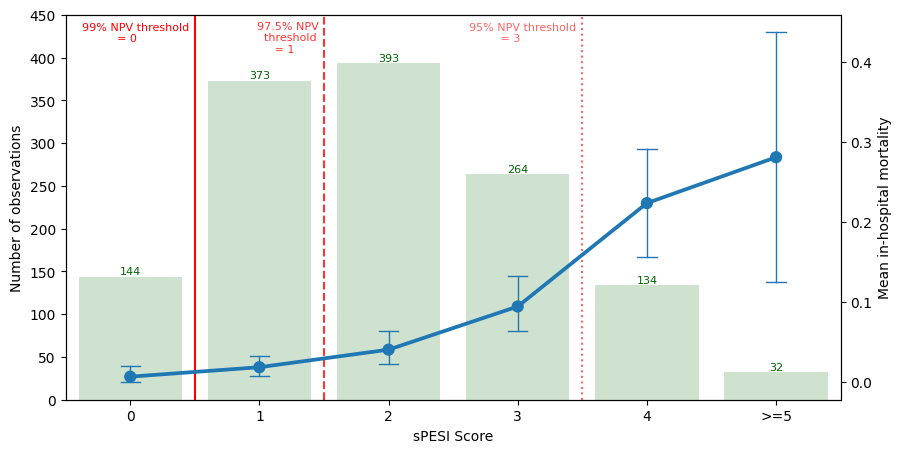

In [23]:
df_pe["sPESI_score_fig"] = df_pe.sPESI_score.map({0: "0", 1:"1", 2:"2", 3:"3", 4:"4", 5:">=5", 6:">=5"})
cat_order = ["0", "1", "2", "3", "4", ">=5"]
df_pe["sPESI_score_fig"] = pd.Categorical(df_pe["sPESI_score_fig"], categories=cat_order, ordered=True)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot with counts per score group
counts = df_pe["sPESI_score_fig"].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values, alpha=0.2, color="green", ax=ax1)
ax1.set_xlabel("sPESI Score", fontsize=10)
ax1.set_ylabel("Number of observations", fontsize=10)

# Adding the number of observations at the top of each bar
for i, p in enumerate(ax1.patches):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()

        
    ax1.text(x, y, counts.values[i], ha='center', va='bottom', fontsize=8, color="darkgreen")

    
ax1.set(ylim=(0, 450))

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Pointplot
sns.pointplot(data=df_pe, x="sPESI_score_fig", y="hospitaldischargestatus",
              errwidth=1, capsize=0.15, ax=ax2)
ax2.set_ylabel("Mean in-hospital mortality", fontsize=10)

# Vertical red line at the 5th score bin
ax1.axvline(x=0.5, color='red', linestyle='-')
ax1.text(x=(-0.37), y=(ax1.get_ylim()[1] * 0.93), s='99% NPV threshold \n          = 0', color='red', fontsize=8)

ax1.axvline(x=1.5, color='red', linestyle='--', alpha=0.8)
ax1.text(x=(0.98), y=((ax1.get_ylim()[1] * 0.93)-12), s='97.5% NPV \n  threshold\n     = 1', color='red', alpha=0.8, fontsize=8)

ax1.axvline(x=3.5, color='red', linestyle='dotted', alpha=0.6)
ax1.text(x=(2.62), y=(ax1.get_ylim()[1] * 0.93), s='95% NPV threshold\n         = 3', color='red', alpha=0.6, fontsize=8)


plt.show()
plt.clf()


<Figure size 640x480 with 0 Axes>

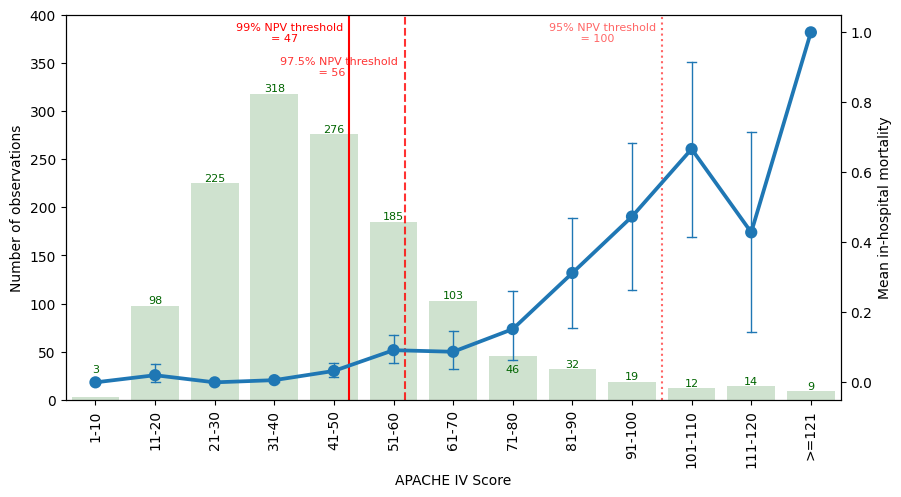

In [24]:
def custom_bin(value):
    if value >= 121:
        return ">=121"
    else:
        lower = (value - 1) // 10 * 10 + 1
        upper = lower + 9
        return f"{lower}-{upper}"

df_pe["apachescore_bins"] = df_pe["apachescore"].apply(custom_bin)

cat_order = [f"{i}-{i+9}" for i in range(1, 121, 10)] + [">=121"]
df_pe["apachescore_bins"] = pd.Categorical(
    df_pe["apachescore_bins"], categories=cat_order, ordered=True)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot with counts per score group
counts = df_pe["apachescore_bins"].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values, alpha=0.2, color="green", ax=ax1)
ax1.set_xlabel("APACHE IV Score", fontsize=10)
ax1.set_ylabel("Number of observations", fontsize=10)

# Adding the number of observations at the top of each bar
for i, p in enumerate(ax1.patches):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    
    if i == 0:
        y += 23
    elif i==7:
        y -= 20

        
    ax1.text(x, y, counts.values[i], ha='center', va='bottom', fontsize=8, color="darkgreen")

    
ax1.set(ylim=(0, 400))

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Pointplot
sns.pointplot(data=df_pe, x="apachescore_bins", y="hospitaldischargestatus",
              errwidth=1, capsize=0.15, ax=ax2)
ax2.set_ylabel("Mean in-hospital mortality", fontsize=10)

# Vertical red line at the 5th score bin
ax1.axvline(x=4.25, color='red', linestyle='-')
ax1.text(x=(2.35), y=(ax1.get_ylim()[1] * 0.93), s='99% NPV threshold \n          = 47', color='red', fontsize=8)

ax1.axvline(x=5.2, color='red', linestyle='--', alpha=0.8)
ax1.text(x=(3.1), y=((ax1.get_ylim()[1] * 0.93)-35), s='97.5% NPV threshold\n           = 56', color='red', alpha=0.8, fontsize=8)

ax1.axvline(x=9.5, color='red', linestyle='dotted', alpha=0.6)
ax1.text(x=(7.6), y=(ax1.get_ylim()[1] * 0.93), s='95% NPV threshold\n         = 100', color='red', alpha=0.6, fontsize=8)

# Rotate x-axis labels
for label in ax1.get_xticklabels():
    label.set_rotation(90)
    

plt.show()
plt.clf()